# Index
- [Imports](#Imports)
- [CTEPG](#CTEPG-(Catching-The-Elusive-Predictable-Genes)-15-06-2020---22-06-2020)
- [Dyslipid database creation](#Creating-dyslipid-dataset)
- [Match / unmatch new results to old results (benign/pathogenic)](#AUC-validation-vanilla-new-model)
- [Model 1 overviews (only run when xgboost 0.72.1 is installed)](#Model-1.0-statistics)
- [New 2.0 models](#2.0-Base-models)
- [Model 2.0 without bugs](#Actual-correct-2.0-model-without-bugs.)
- [Original model](#Original-model)
- [Cross validated models](#CV-Models)
- [XGB models out of CV models](#New-Models)
- [Mismatch analysis](#Mismatch-analysis)
- [AUC analysis base model](#Full-dataset-AUC-analysis)
- [AUC analysis dyslipid model](#AUC-analysis-of-dyslipid-model)
- [AUC analysis erfelijke kanker model](#AUC-analysis-on-EK-model)
- [Model on best performing panel, preparation](#Model-on-best-performing-panel,-prepartation)
- [AUC analysis new model on UMCG genepanels](#AUC-analysis-new-model-on-UMCG-genepanels)
- [AUC correction UMCG genepanel analysis](#Corrected-UMCG-genepanel-analysis)
- [Barplot of type of variants for each panel](#Barplot-of-type-of-variants-for-each-panel)

# Imports

In [1]:
# Importing some shizzle.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import time
import requests
import datetime
import sys
import os
import pathlib
import seaborn as sns
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
import math
import json
import glob
import gzip
import pickle
import xgboost as xgb
from utilities import perform_stats, calc_z_scores
from utilities import get_header, genepanel_analysis, auc_analysis_function
from utilities import analyze_auc_per_gene, correct_threshold, read_capice_output
from sklearn.metrics import recall_score, roc_auc_score, precision_score, f1_score

# Defining some import and export locations
location = 'rjsietsma'
read_loc = '/run/media/rjsietsma/evo2tb/linux/Datafiles/'
data_expor_loc = '/home/'+location+'/Documents/School/Master_DSLS/Final_Thesis/Past_initial_data/'
img_output_dir = '/home/'+location+'/PycharmProjects/dsls_master_thesis/side_scripts/output_img/'

with open('./umcg_genepanels.json', 'r') as panels:
    genepanels = json.load(panels)
    genepanels.pop('5GPM', None)

 # CTEPG (Catching The Elusive Predictable Genes) 15-06-2020 - 22-06-2020
 [Index](#Index)
<br/><br/>

What have I done:

- Made plot of Panel vs all combined:
![Panel vs all combined](img/allvs1boxplot_umcggenepanels.png)

- Issued [pull request](https://github.com/molgenis/capice/pull/1) for Dennis and Bart to be able to work with CAPICE locally.
- Refactored CAPICE code _(not finished)_.
- Retrained new models.
- Found new Pathogenic / Benign threshold within CAPICE.
- Made fancy new notebook with [indexing](#Index).



Planned for this week:
- Make barplot of type of variants for each panel.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Rebuild benchmarking dataset to the full dataset in Initial Data Exploration.
- Model refinement:
    - AUC analysis of new model (model xgb_booster37.pickle.dat)
    - Check for improvements.
    - Then split the training / testing data in the different models. (xgb_booster37.pickle.dat and xgb_booster_dyslipid.pickle.dat)
        - Also do the full dataset on dyslipid. Do not try to split the data into the 2 models. 
        - Try to build new models on average performing and well performing panels aswell, try to see if everything improves nicely.
            - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
        - _Note: Shuang her data has almost half the variants than the newer VGKL and Clinvar datasets, with 3913 benign and 1116 malignant samples._
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 22-06-2020 - 29-06-2020
[Index](#Index)
<br/><br/>

What have I done:

- Made models: Dyslipid and Erfelijke kanker
- AUC analysis of dyslipid panel
    - Interestingly: it performs only SLIGHTLY better than the 2.0 base model:
<br/><br/>

AUC 2.0 base:

- Test: 0.7743036340158642
- Train: 0.9822742260567594

AUC 2.0 Dyslipid:

- Test: 0.7770706511713705
- Train: 0.9827123551221991
<br/><br/>

    - Note: AUC analysis is performed with an updated threshold, see the correct_threshold function.
    
- [CAPICE refactoring in progress](https://github.com/SietsmaRJ/capice/tree/refactoring)

Planned for this week:
- Make new 2.0 base models playing around with param_dist in train_model.py
    - Back to basic, train model on train.txt.gz, with default hyperparameters of LR: 0.1, max_depth = 15 and n_estimators=422.
        - AUC analysis. Test should match AUC of 0.85
    - New 2.0 models should match old model for test dataset at AUC ~0.85
    - Split up train.txt.gz to a test and train dataset and have test.txt.gz as some sort of validation dataset.
- ~Make barplot of type of variants for each panel.~
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
    
Capice 2.0:
- For which transcript is the score calculated?
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 22-06-2020 - 29-06-2020
[Index](#Index)
<br/><br/>

What have I done:

- Made models: Base 2.0, Dyslipid
    - End AUC base: validation_0-auc:0.97662
    - End AUC dyslipid: validation_0-auc:0.98676
- [Make barplot of type of variants for each panel.]()

    
- [CAPICE refactoring in progress](https://github.com/SietsmaRJ/capice/tree/refactoring)

Planned for this week:
- Make new 2.0 base models playing around with param_dist in train_model.py
    - Back to basic, train model on train.txt.gz, with default hyperparameters of LR: 0.1, max_depth = 15 and n_estimators=422.
        - AUC analysis. Test should match AUC of 0.85
    - New 2.0 models should match old model for test dataset at AUC ~0.85
    - Split up train.txt.gz to a test and train dataset and have test.txt.gz as some sort of validation dataset.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
    
Capice 2.0:
- For which transcript is the score calculated?
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 06-07-2020 - 13-07-2020
[Index](#Index)
<br/><br/>

Planned for this week:
- Investigate whenever [github](https://github.com/molgenis/capice) model is up to date with the GCC cluster model.
- Add select_balanced_benign_dataset function in train_model.py
    - See step4_xgboost_finetune....py, line 20-65 for more details.
    - Also export this dataset that it makes for validation.
- Recheck all AUC analysis that I did.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
    
Capice 2.0:
- For which transcript is the score calculated?
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 06-07-2020 - 13-07-2020
[Index](#Index)
<br/><br/>

Planned for this week:
- ~Recheck AUC analysis of model 1.0.~
- Make Mann-Whitney plots more readable, including the mean and STD of the genepanels.
- Make scatterplot of AUC vs number of variants in genepanels.
    - Do the same for AUC vs number of pathogenic variants.
    - Same for AUC vs number of benign variants.
- Make specific models for
    - 1: Bad performing panel (Hart- en vaatziekten)
    - 2: Well performing panel (Neurogenetica)
    - 3: Average performing panel (random)
        - Make these specific models with an unbalanced and balanced dataset and see what is really required for these panels and models to perform better.
- Investigate overlapping genes within the genepanels.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
    
(Discussable to continue with)

- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
<br/><br/>

# Creating dyslipid dataset
[Index](#Index)

In [2]:
file_loc = os.path.join(read_loc, 'train.txt.gz')
header = get_header(file_loc, '#Chrom')
train = pd.read_csv(file_loc, compression='gzip', names=header, comment='#', sep='\t', low_memory=False)
train

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
0,14,False,G,CodingTranscript,False,False,CCDS9787.1,806.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.843,False,1.0
1,20,False,T,CodingTranscript,True,False,CCDS13112.1,1899.0,True,"frameshift,stop_gained",...,NaN,NaN,vkgl,NaN,NaN,False,1.000,4.670,False,1.0
2,20,False,C,CodingTranscript,True,False,CCDS13112.1,2118.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.043,False,1.0
3,20,False,A,CodingTranscript,True,False,CCDS13112.1,1586.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.221,False,1.0
4,20,False,A,Intergenic,True,False,NaN,NaN,True,downstream,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.368,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334596,17,False,A,CodingTranscript,False,False,CCDS32642.1,1563.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,6.031,False,0.8
334597,17,False,T,CodingTranscript,False,False,CCDS32642.1,2029.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,4.100,False,0.8
334598,10,False,T,CodingTranscript,False,False,CCDS7431.1,1216.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,5.852,False,0.8
334599,2,False,T,CodingTranscript,False,False,CCDS2382.1,2998.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.031,2.213,False,0.8


In [3]:
with open('./umcg_genepanels.json', 'r') as json_file:
    genes = json.load(json_file)
dislipid_genes = genes['Hart- en vaatziekten']
genelist = []
for key, value in dislipid_genes.items():
    if key.lower().startswith('dyslipid'):
        for g in value:
            if g not in genelist:
                genelist.append(g)

In [4]:
dislipid_subset = train.loc[train['GeneName'].isin(genelist)]
dislipid_subset

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
142,16,False,T,CodingTranscript,False,False,CCDS10772.1,848.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.928,2.614,False,1.0
148,19,False,CCGGCGAGGTGCAGGCCATGCT,CodingTranscript,False,False,CCDS12647.1,409.0,True,protein_altering,...,NaN,NaN,vkgl,NaN,NaN,True,0.863,0.839,False,1.0
149,2,False,C,CodingTranscript,False,False,CCDS1703.1,13028.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.000,0.058,False,1.0
150,2,False,G,CodingTranscript,False,False,CCDS1703.1,28.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.021,-0.103,False,1.0
151,2,False,C,CodingTranscript,False,False,CCDS1703.1,2534.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.653,0.251,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334284,12,False,T,CodingTranscript,False,False,CCDS8685.1,1093.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.999,3.072,False,0.8
334285,12,False,A,CodingTranscript,False,False,CCDS8685.1,1475.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.580,0.563,False,0.8
334286,12,False,T,CodingTranscript,False,False,CCDS8685.1,1537.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.003,0.643,False,0.8
334287,12,False,G,CodingTranscript,False,False,CCDS8685.1,1553.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.510,2.765,False,0.8


In [5]:
dislipid_subset['label'].value_counts()

Benign        3913
Pathogenic    1116
Name: label, dtype: int64

# Model 1.0 statistics
[Index](#Index)

In [6]:
# model_gcc = pickle.load(open('./test_output/model_2_0/default_hyper/base/xgb_gcc_cluster.pickle.dat', 'rb'))
# model_gcc.attributes()

In [7]:
# model_github = pickle.load(open('./test_output/model_2_0/default_hyper/base/xgb_github.pickle.dat', 'rb'))
# model_github.attributes()

In [8]:
test_gcc = read_capice_output('./test_output/test_gccmodel_0721.txt')
test_git = read_capice_output('./test_output/test_githubmodel_0721.txt')
print(test_gcc.shape[0])
test_gcc = test_gcc.append(test_git)
print(test_gcc.shape[0])
test_gcc.drop_duplicates(inplace=True)
print(test_gcc.shape[0])

10842
21684
10842


# 2.0 Base models
[Index](#Index)

### Threshold analysis

In [9]:
train_base20 = read_capice_output('./test_output/model_2_0/result_files/train_base2_0.txt')
train_base20

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,FRAME_SHIFT,26.600,9.999967e-01,Pathogenic,Pathogenic,17,41246652,ACATTC,GA
1,LDLR,FRAME_SHIFT,35.000,9.999961e-01,Pathogenic,Pathogenic,19,11216252,GACAAA,TTT
2,LDLR,FRAME_SHIFT,34.000,9.999925e-01,Pathogenic,Pathogenic,19,11216255,AAATCTGACG,TGCAA
3,LDLR,FRAME_SHIFT,34.000,9.999908e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA
4,BRCA1,FRAME_SHIFT,27.300,9.999901e-01,Pathogenic,Pathogenic,17,41246611,AG,A
...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SYNONYMOUS,6.942,3.544337e-07,Neutral,Neutral,17,10404694,G,A
334597,LIG4,3PRIME_UTR,1.122,3.442061e-07,Neutral,Neutral,13,108860318,C,CATT
334598,MIR548AZ,NON_SYNONYMOUS,12.180,3.056727e-07,Neutral,Neutral,14,64519911,G,A
334599,MIR548AZ,SYNONYMOUS,15.650,2.615435e-07,Neutral,Neutral,14,64692103,G,A


In [10]:
# correct_threshold(train_base20)

In [11]:
test_base20 = read_capice_output('./test_output/model_2_0/result_files/test_base2_0.txt')
print("XGBoost 1.1.1, python3.8, threshold 0.02:")
auc_analysis_function(train_base20, test_base20)

XGBoost 1.1.1, python3.8, threshold 0.02:
AUC analysis of the training dataset reveals AUC: 0.9971556578875161
AUC analysis of the testing dataset reveals AUC: 0.8937102839970584


In [12]:
train_base20ct = read_capice_output('./test_output/model_2_0/result_files/train_base_xgboost_correctthres.txt')
test_base20ct = read_capice_output('./test_output/model_2_0/result_files/test_base_xgboost_correctthres.txt')
print("XGboost 1.1.1, python3.8, using threshold 0.149:")
auc_analysis_function(train_base20ct, test_base20ct)

XGboost 1.1.1, python3.8, using threshold 0.149:
AUC analysis of the training dataset reveals AUC: 0.9971556578875161
AUC analysis of the testing dataset reveals AUC: 0.8937102839970584


Why is base 2.0 model not showing a threshold close to 0.02?
#### Investigating original threshold

In [13]:
train_base = read_capice_output('./test_output/model_2_0/result_files/train_base_xgboost_0721.txt')
train_base

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,FRAME_SHIFT,26.600,9.999933e-01,Pathogenic,Pathogenic,17,41246652,ACATTC,GA
1,LDLR,FRAME_SHIFT,35.000,9.999907e-01,Pathogenic,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG
2,LDLR,FRAME_SHIFT,34.000,9.999896e-01,Pathogenic,Pathogenic,19,11216251,GGACAAATCTGACGA,AACTGCGGTAAACTGCGGTAAACT
3,LDLR,FRAME_SHIFT,34.000,9.999894e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA
4,MSH2,FRAME_SHIFT,35.000,9.999891e-01,Pathogenic,Pathogenic,2,47702328,GTTGA,TTTC
...,...,...,...,...,...,...,...,...,...,...
334596,MIR548AZ,SYNONYMOUS,14.370,2.765540e-07,Neutral,Neutral,14,64653189,T,C
334597,MYHAS,SYNONYMOUS,0.611,2.524258e-07,Neutral,Neutral,17,10419945,A,G
334598,MYHAS,SYNONYMOUS,9.827,2.164549e-07,Neutral,Neutral,17,10419849,T,G
334599,LOC100289580,SYNONYMOUS,14.100,1.984229e-07,Neutral,Neutral,16,88804658,G,A


In [14]:
# train_base_recall, train_base_threshold = correct_threshold(train_base)

In [15]:
train_in = pd.read_csv(
     '~/PycharmProjects/dsls_master_thesis/'
     'side_scripts/datafiles/train.txt.gz',
      compression='gzip', sep='\t', low_memory=False)
data = train_base.merge(
     train_in[['#Chrom', 'Pos', 'Ref', 'Alt', 'label']],
     left_on=['chr', 'pos', 'ref', 'alt'],
     right_on=['#Chrom', 'Pos', 'Ref', 'Alt'])
drop_labels = ['#Chrom', 'Pos', 'Ref', 'Alt']
for x in data.columns:
    if x.endswith('_x') or x.endswith('_y'):
        drop_labels.append(x)
data.drop(columns=drop_labels, inplace=True)
data

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,label
0,BRCA1,FRAME_SHIFT,26.600,9.999933e-01,Pathogenic,Pathogenic,17,41246652,ACATTC,GA,Pathogenic
1,LDLR,FRAME_SHIFT,35.000,9.999907e-01,Pathogenic,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,Pathogenic
2,LDLR,FRAME_SHIFT,34.000,9.999896e-01,Pathogenic,Pathogenic,19,11216251,GGACAAATCTGACGA,AACTGCGGTAAACTGCGGTAAACT,Pathogenic
3,LDLR,FRAME_SHIFT,34.000,9.999894e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA,Pathogenic
4,MSH2,FRAME_SHIFT,35.000,9.999891e-01,Pathogenic,Pathogenic,2,47702328,GTTGA,TTTC,Pathogenic
...,...,...,...,...,...,...,...,...,...,...,...
334596,MIR548AZ,SYNONYMOUS,14.370,2.765540e-07,Neutral,Neutral,14,64653189,T,C,Benign
334597,MYHAS,SYNONYMOUS,0.611,2.524258e-07,Neutral,Neutral,17,10419945,A,G,Benign
334598,MYHAS,SYNONYMOUS,9.827,2.164549e-07,Neutral,Neutral,17,10419849,T,G,Benign
334599,LOC100289580,SYNONYMOUS,14.100,1.984229e-07,Neutral,Neutral,16,88804658,G,A,Benign


In [16]:
def default_threshold(row):
    return_value = 0
    if row > 0.02:
        return_value = 1
    return return_value

In [17]:
data['pred'] = data['probabilities'].apply(lambda x: default_threshold(x))

In [18]:
data['label'].replace({'Pathogenic': 1, 'Benign': 0}, inplace=True)

In [19]:
y_true = np.array(data['label'])
y_pred = np.array(data['pred'])
print(f"The recall score of using Python3.8 and threshold 0.02 is: {recall_score(y_true, y_pred)}")
print(f"The precision score of using Python3.8 and threshold 0.02 is: {precision_score(y_true, y_pred)}")
print(f"Resulting in a F1 score of: {f1_score(y_true, y_pred)}")

The recall score of using Python3.8 and threshold 0.02 is: 0.9893316290160026
The precision score of using Python3.8 and threshold 0.02 is: 0.7102746011577016
Resulting in a F1 score of: 0.8268940366736864


In [20]:
test_base = read_capice_output('./test_output/model_2_0/result_files/test_base_xgboost_0721.txt')
test_base

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,MSH2,FRAME_SHIFT,34.000,0.999988,Pathogenic,Pathogenic,2,47639582,AGAAA,TAAT
1,BRCA1,FRAME_SHIFT,22.000,0.999986,Pathogenic,Pathogenic,17,41245330,CTTTA,TTT
2,BRCA1,STOP_GAINED,34.000,0.999983,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT
3,BRCA2,FRAME_SHIFT,17.090,0.999981,Pathogenic,Pathogenic,13,32906819,GG,G
4,BRCA2,FRAME_SHIFT,22.300,0.999981,Pathogenic,Pathogenic,13,32913009,TC,T
...,...,...,...,...,...,...,...,...,...,...
10837,MIR548AZ,NON_SYNONYMOUS,5.220,0.000002,Neutral,Neutral,14,64593063,G,A
10838,LOC100289580,UPSTREAM,1.856,0.000002,Neutral,Neutral,16,88798720,G,A
10839,MYHAS,DOWNSTREAM,0.035,0.000002,Neutral,Neutral,17,10442488,G,A
10840,MIR548AZ,NON_SYNONYMOUS,1.347,0.000001,Neutral,Neutral,14,64519932,A,G


In [21]:
print('Using XGboost 0.72.1 on python3.8, default threshold (0.02):')
auc_analysis_function(train_base, test_base)

Using XGboost 0.72.1 on python3.8, default threshold (0.02):
AUC analysis of the training dataset reveals AUC: 0.9971523753640674
AUC analysis of the testing dataset reveals AUC: 0.893641835924645


##### AUC analysis, but now with a new threshold.


In [22]:
train_basect = read_capice_output('./test_output/model_2_0/result_files/train_base_xgboost_0721_correctthres.txt')
test_basect = read_capice_output('./test_output/model_2_0/result_files/test_base_xgboost_0721_correctthres.txt')
print("Using XGboost 0.72.1 on python3.8, threshold set to 0.152:")
auc_analysis_function(train_basect, test_basect)

Using XGboost 0.72.1 on python3.8, threshold set to 0.152:
AUC analysis of the training dataset reveals AUC: 0.9971523753640674
AUC analysis of the testing dataset reveals AUC: 0.893641835924645


# Actual correct 2.0 model without bugs.
[Index](#Index)

In [23]:
default_hyper_version111_model = pickle.load(open('./test_output/model_2_0/default_hyper/base/xgb_defaulthyper_111.pickle.dat', 'rb'))
default_hyper_version111_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.10495845238185281, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=422, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [24]:
train_forsure_default = read_capice_output('./test_output/model_2_0/default_hyper/result_files/train_defaulthyper_nothres.txt')
test_forsure_default = read_capice_output('./test_output/model_2_0/default_hyper/result_files/test_defaulthyper_nothres.txt')
print('Model 2.0, default hyperparameters, xgboost 1.1.1, python3.7, threshold 0.02:')
auc_analysis_function(train_forsure_default, test_forsure_default)

Model 2.0, default hyperparameters, xgboost 1.1.1, python3.7, threshold 0.02:
AUC analysis of the training dataset reveals AUC: 0.9971556579293329
AUC analysis of the testing dataset reveals AUC: 0.893710301011245


In [25]:
# correct_threshold(train_results=train_forsure_default, include_upper=True)

In [28]:
test_forsure_default

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,STOP_GAINED,34.000,0.999991,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT
1,BRCA2,FRAME_SHIFT,26.900,0.999990,Pathogenic,Pathogenic,13,32912883,CTG,TT
2,BRCA2,FRAME_SHIFT,24.100,0.999989,Pathogenic,Pathogenic,13,32914822,TAA,T
3,BRCA2,FRAME_SHIFT,25.600,0.999989,Pathogenic,Pathogenic,13,32913442,TC,T
4,BRCA1,FRAME_SHIFT,19.390,0.999988,Pathogenic,Pathogenic,17,41246507,CAG,C
...,...,...,...,...,...,...,...,...,...,...
10837,SYNE1,SPLICE_SITE,14.930,0.000002,Neutral,Neutral,6,152722482,T,C
10838,NBPF20,REGULATORY,3.320,0.000002,Neutral,Neutral,1,145439717,C,G
10839,NBPF20,REGULATORY,3.306,0.000001,Neutral,Neutral,1,145440240,C,T
10840,MIR548AZ,NON_SYNONYMOUS,5.553,0.000001,Neutral,Neutral,14,64537567,G,C


In [29]:
train_forsure_oldmodel = read_capice_output('./test_output/model_2_0/default_hyper/result_files/train_xgboost0721_defaulthyper.txt')
test_forsure_oldmodel = read_capice_output('./test_output/model_2_0/default_hyper/result_files/test_xgboost0721_defaulthyper.txt')
print('Model 1.0, default hyperparameters, xgboost 0.72.1, python3.8, threshold 0.02, forced xgboost install:')
auc_analysis_function(train_forsure_oldmodel, test_forsure_oldmodel)

Model 1.0, default hyperparameters, xgboost 0.72.1, python3.8, threshold 0.02, forced xgboost install:
AUC analysis of the training dataset reveals AUC: 0.9971523753640674
AUC analysis of the testing dataset reveals AUC: 0.893641835924645


# Original model
[Index](#Index)

In [30]:
train_python36 = read_capice_output('./test_output/model_2_0/result_files/train_python36_defaultthres.txt')
test_python36 = read_capice_output('./test_output/model_2_0/result_files/test_python36_defaultthres.txt')
print("Using python3.6, xgboost 0.72.1, threshold default:")
auc_analysis_function(train_python36, test_python36)

Using python3.6, xgboost 0.72.1, threshold default:
AUC analysis of the training dataset reveals AUC: 0.9971523753640674
AUC analysis of the testing dataset reveals AUC: 0.893641835924645


Confirmed: The 2.0 model performs just as good as model 1.0

# CV Models
[Index](#Index)

In [31]:
model = pickle.load(open('./models/xgb_weightedSample_randomsearch_v2.pickle.dat', 'rb'))
xgbmodel = model.best_estimator_

In [32]:
model_dislipid = pickle.load(open('./models/xgb_weightedSample_randomsearch_dislipid.pickle.dat', 'rb'))
xgbmodel_dislipid = model_dislipid.best_estimator_
xgbmodel_dislipid.get_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.1968770013672272,
 'max_delta_step': 0,
 'max_depth': 16,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 427,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 1}

In [33]:
model_ek = pickle.load(open('./models/xgb_ransearch_ek_dataset.pickle.dat', 'rb'))

# New Models
[Index](#Index)

In [34]:
model = pickle.load(open('./xgbmodels/xgb_booster_v2.pickle.dat', 'rb'))
model.feature_importances_

array([0.00282909, 0.00207738, 0.00183909, 0.00320904, 0.00281486,
       0.00190347, 0.00192447, 0.00191927, 0.00175739, 0.00351866,
       0.00253019, 0.00301028, 0.00308079, 0.00301589, 0.00242207,
       0.00284953, 0.00254809, 0.00301885, 0.00276217, 0.00329895,
       0.0029472 , 0.00288387, 0.00196225, 0.00324255, 0.00249287,
       0.00308638, 0.00275804, 0.00326703, 0.003321  , 0.02822421,
       0.01098935, 0.00849544, 0.0026135 , 0.0021958 , 0.00212344,
       0.02957111, 0.00307086, 0.00227875, 0.00224516, 0.00332749,
       0.00291972, 0.00251198, 0.00405553, 0.00422445, 0.00319547,
       0.00250752, 0.00358728, 0.0023705 , 0.00314594, 0.00369558,
       0.00300821, 0.00350186, 0.00383268, 0.00286349, 0.00239821,
       0.00318689, 0.00370395, 0.00359068, 0.00305595, 0.01804393,
       0.00381216, 0.00197791, 0.0018304 , 0.0023901 , 0.00244684,
       0.00294106, 0.00317492, 0.00303257, 0.00199907, 0.00196537,
       0.00232091, 0.00312337, 0.00172605, 0.00178056, 0.     

In [35]:
model_dislipid = pickle.load(open('./xgbmodels/xgb_booster_dyslipid.pickle.dat', 'rb'))
model_dislipid.feature_importances_

array([0.00278866, 0.00208772, 0.00174322, 0.00296931, 0.00269667,
       0.00179555, 0.00186813, 0.00186437, 0.00175499, 0.00395201,
       0.00240749, 0.00280701, 0.00290935, 0.00285559, 0.0023123 ,
       0.0027687 , 0.0024073 , 0.00306501, 0.00286279, 0.00350749,
       0.00261141, 0.00282689, 0.00188535, 0.00320358, 0.00238541,
       0.00293148, 0.00261692, 0.00331071, 0.00368271, 0.02656523,
       0.01037843, 0.00846208, 0.00255091, 0.00212624, 0.00206606,
       0.03021989, 0.0027948 , 0.00225078, 0.00219586, 0.00343691,
       0.00298393, 0.00254942, 0.00387159, 0.00394147, 0.00327632,
       0.00257063, 0.00359947, 0.00250112, 0.00339626, 0.00355939,
       0.0030033 , 0.00344496, 0.00338445, 0.00294264, 0.00213853,
       0.00313247, 0.00377457, 0.00349594, 0.00298174, 0.01875002,
       0.00379864, 0.00185824, 0.00179364, 0.00239529, 0.00231335,
       0.00317147, 0.00292523, 0.00316273, 0.00262851, 0.00228997,
       0.00601442, 0.00521736, 0.00169761, 0.00183883, 0.     

In [36]:
model_ek = model_ek.best_estimator_
model_ek.feature_importances_

array([5.0133662e-03, 1.2882849e-03, 1.0817926e-03, 6.3643702e-03,
       2.4500915e-03, 1.2766811e-03, 1.6910619e-03, 1.9211929e-03,
       1.3221180e-03, 1.4542753e-03, 1.7586007e-03, 3.7318198e-03,
       1.4746373e-03, 2.0313114e-03, 1.3998400e-03, 1.0245102e-03,
       1.8737183e-03, 1.2974218e-03, 1.8016534e-03, 1.4174232e-03,
       1.7281594e-03, 2.0112914e-03, 1.3021030e-03, 1.5508684e-03,
       2.8008316e-03, 1.2582513e-03, 1.9976879e-03, 2.1160368e-03,
       2.7596293e-02, 4.1479445e-03, 1.9538682e-02, 1.1834032e-02,
       1.5302061e-03, 1.3707022e-03, 1.8456797e-03, 2.6172997e-02,
       2.8442349e-03, 1.3298710e-03, 1.2373156e-03, 1.3766757e-03,
       1.9199389e-03, 1.9936443e-03, 4.2407308e-03, 2.6613504e-03,
       4.2698625e-03, 1.5507338e-03, 2.0464479e-03, 1.2644089e-03,
       1.8295237e-03, 2.7150142e-03, 2.2141868e-03, 4.2772172e-03,
       4.4871587e-03, 1.0170736e-03, 1.9717950e-03, 1.3658322e-03,
       1.7440096e-03, 1.4196830e-03, 1.5646445e-03, 1.7786717e

# Mismatch analysis
[Index](#Index)

In [37]:
train_original = pd.read_csv('/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/train_results.txt', sep='\t', low_memory=False)
train_original

,chr,pos,ref,alt,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction
0,17,41246652,ACATTC,GA,BRCA1,FRAME_SHIFT,26.600,9.999933e-01,Pathogenic,Pathogenic
1,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,LDLR,FRAME_SHIFT,35.000,9.999907e-01,Pathogenic,Pathogenic
2,19,11216251,GGACAAATCTGACGA,AACTGCGGTAAACTGCGGTAAACT,LDLR,FRAME_SHIFT,34.000,9.999896e-01,Pathogenic,Pathogenic
3,19,11216262,ACG,CA,LDLR,FRAME_SHIFT,34.000,9.999894e-01,Pathogenic,Pathogenic
4,2,47702328,GTTGA,TTTC,MSH2,FRAME_SHIFT,35.000,9.999891e-01,Pathogenic,Pathogenic
...,...,...,...,...,...,...,...,...,...,...
334596,14,64653189,T,C,MIR548AZ,SYNONYMOUS,14.370,2.765540e-07,Neutral,Neutral
334597,17,10419945,A,G,MYHAS,SYNONYMOUS,0.611,2.524258e-07,Neutral,Neutral
334598,17,10419849,T,G,MYHAS,SYNONYMOUS,9.827,2.164549e-07,Neutral,Neutral
334599,16,88804658,G,A,LOC100289580,SYNONYMOUS,14.100,1.984229e-07,Neutral,Neutral


In [38]:
train_new = read_capice_output('./datafiles/train_results_v4.txt.gz')
train_new

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,LDLR,FRAME_SHIFT,35.000,9.999982e-01,Pathogenic,Pathogenic,19,11216252,GACAAA,TTT
1,BRCA2,FRAME_SHIFT,35.000,9.999978e-01,Pathogenic,Pathogenic,13,32936775,GAATTT,AG
2,LDLR,FRAME_SHIFT,35.000,9.999976e-01,Pathogenic,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG
3,LDLR,FRAME_SHIFT,34.000,9.999967e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA
4,BRCA2,FRAME_SHIFT,20.800,9.999956e-01,Pathogenic,Pathogenic,13,32906847,TACCCCTATTG,ACAT
...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SYNONYMOUS,10.130,7.769997e-08,Neutral,Neutral,17,10429043,G,A
334597,MYHAS,SYNONYMOUS,15.280,7.578360e-08,Neutral,Neutral,17,10415744,A,G
334598,MIR1273H,SYNONYMOUS,13.040,6.680243e-08,Neutral,Neutral,4,39448569,G,A
334599,MYHAS,SYNONYMOUS,12.770,5.909591e-08,Neutral,Neutral,17,10318882,G,A


In [39]:
merge = train_original[['chr', 'pos','ref','alt','prediction']].merge(train_new[['chr', 'pos','ref','alt','prediction']],
                                                                     on=['chr', 'pos','ref','alt'])
merge[merge['prediction_x'] != merge['prediction_y']]
print(f"There is a "
      f"{merge[merge['prediction_x'] != merge['prediction_y']].shape[0] / train_original.shape[0] * 100}% mismatch.")

There is a 4.3523480204781215% mismatch.


In [40]:
test_original = pd.read_csv('/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/test_results.txt', sep='\t', low_memory=False)
tellPathogenic_pred = lambda x: "Pathogenic" if x > 0.02 else 'Neutral'
test_original['prediction'] = [tellPathogenic_pred(probability) for probability in test_original['capice']]
test_original.rename(columns={'#Chrom': 'chr', 'Pos':'pos', 'Ref': 'ref', 'Alt':'alt'}, inplace=True)
test_original

,chr,pos,ref,alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,prediction
0,21,33974174,C,G,0.000058,STOP_LOST,LB/B,NaN,NaN,NaN,NaN,15.050,NaN,0.003275,NaN,Neutral
1,X,99661625,G,C,0.000037,SYNONYMOUS,LB/B,NaN,NaN,0.000,-0.0,0.806,NaN,0.000075,NaN,Neutral
2,17,29509638,C,T,0.000000,SYNONYMOUS,LB/B,NaN,NaN,0.647,-0.0,10.760,NaN,0.001511,NaN,Neutral
3,21,35742999,C,T,0.000133,SYNONYMOUS,LB/B,NaN,NaN,0.000,-0.0,18.640,NaN,0.000621,NaN,Neutral
4,1,2160973,G,A,0.000000,SYNONYMOUS,LB/B,NaN,NaN,0.000,-0.0,16.340,0.008252,0.000012,NaN,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10837,17,29556342,G,A,0.000000,SYNONYMOUS,LP/P,NaN,NaN,0.000,-0.0,11.450,NaN,0.000139,NaN,Neutral
10838,11,5248177,A,T,0.000344,SYNONYMOUS,LP/P,NaN,NaN,0.000,-0.0,17.970,NaN,0.069934,NaN,Pathogenic
10839,15,48787324,T,C,0.000000,SYNONYMOUS,LP/P,NaN,NaN,0.664,-0.0,12.170,0.019530,0.909190,NaN,Pathogenic
10840,19,17947957,G,A,0.000015,SYNONYMOUS,LP/P,NaN,NaN,0.000,-0.0,10.990,NaN,0.001238,NaN,Neutral


In [41]:
test_new = read_capice_output('./datafiles/test_results_v4.txt.gz')
test_new

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,STOP_GAINED,34.000,9.999962e-01,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT
1,BRCA2,FRAME_SHIFT,26.900,9.999943e-01,Pathogenic,Pathogenic,13,32912883,CTG,TT
2,MSH2,FRAME_SHIFT,34.000,9.999934e-01,Pathogenic,Pathogenic,2,47639582,AGAAA,TAAT
3,BRCA2,FRAME_SHIFT,24.100,9.999933e-01,Pathogenic,Pathogenic,13,32912590,TA,T
4,BRCA2,FRAME_SHIFT,25.600,9.999924e-01,Pathogenic,Pathogenic,13,32913442,TC,T
...,...,...,...,...,...,...,...,...,...,...
10837,MIR548AZ,NON_SYNONYMOUS,5.553,1.214339e-06,Neutral,Neutral,14,64537567,G,C
10838,MYHAS,INTRONIC,0.068,8.699849e-07,Neutral,Neutral,17,10432854,G,A
10839,NBPF20,REGULATORY,3.320,6.732982e-07,Neutral,Neutral,1,145439717,C,G
10840,MYHAS,DOWNSTREAM,0.035,6.130708e-07,Neutral,Neutral,17,10442488,G,A


In [42]:
merge = test_original[['chr', 'pos','ref','alt','prediction']].merge(test_new[['chr', 'pos','ref','alt','prediction']],
                                                                     on=['chr', 'pos','ref','alt'])
merge[merge['prediction_x'] != merge['prediction_y']]
print(f"There is a "
      f"{merge[merge['prediction_x'] != merge['prediction_y']].shape[0] / test_original.shape[0] * 100}% mismatch.")

There is a 14.25936174137613% mismatch.


# Full dataset AUC analysis
- Default hyperparameters:
    - learning_rate=0.10495845238185281
    - n_estimators=422
    - max_depth=15
    
[Base, default hyper, balanced ds](#Base-|-Default-hyper-|-balanced-ds)

[Index](#Index)


### Base | Default hyper | model 1.0 | balanced ds?
[(Back)](#Full-dataset-AUC-analysis)

In [43]:
train_output = read_capice_output('./test_output/train_model1.txt')
test_output = read_capice_output('./test_output/test_model1.txt')
train_output, test_output = auc_analysis_function(train_output, test_output, return_value=True)

AUC analysis of the training dataset reveals AUC: 0.9971523753640674
AUC analysis of the testing dataset reveals AUC: 0.893641835924645


In [44]:
train_output['source'] = 'train'
test_output['source'] = 'test'
full = train_output.append(test_output)
full.drop_duplicates(subset=['chr','pos','ref','alt'], inplace=True)
auc_analysis = analyze_auc_per_gene(full, 'auc_analysis_model1.csv')

In [45]:
auc_analysis.sort_values(by='auc').head(10)

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
2314,2314,DFNA5,0.222222,0.000000,0.000000,1.000000,0.00000,36,1,37,37,0
2327,2327,CEACAM16,0.279817,0.000000,0.000000,1.000000,0.00000,218,1,219,216,3
2313,2313,GJB3,0.392045,0.000000,0.000000,1.000000,0.00000,88,2,90,90,0
2308,2308,NTRK2,0.428571,0.000000,0.000000,1.000000,0.00000,14,1,15,14,1
2224,2224,GFM2,0.530702,0.000000,0.000000,1.000000,0.00000,114,2,116,107,9
2277,2277,LDB3,0.557471,0.000000,0.000000,1.000000,0.00000,522,1,523,514,9
2149,2149,KCNE2,0.587065,0.285714,0.333333,0.666667,0.25000,67,3,70,68,2
1970,1970,CEP104,0.598592,0.045455,0.500000,0.500000,0.02381,71,2,73,61,12
2321,2321,KBTBD13,0.602041,0.000000,0.000000,1.000000,0.00000,98,1,99,88,11
2300,2300,NRXN3,0.617284,0.000000,0.000000,1.000000,0.00000,567,1,568,565,3


In [46]:
model1_umcg_genepanel_analysis = genepanel_analysis(genepanels, auc_analysis)
model1_umcg_genepanel_analysis

,two-sided,less,greater,category,compared_to
0,0.155635,0.077817,0.923697,all,Neurogenetica
1,0.524365,0.262182,0.749208,all,Amyloidose
2,0.268751,0.134376,0.867695,all,Hart- en vaatziekten
3,0.047009,0.977207,0.023505,all,Primaire Immuundeficiëntie
4,0.340001,0.170001,0.833264,all,Huidziekten
5,0.736763,0.635699,0.368382,all,Epilepsie
6,0.123920,0.942244,0.061960,all,Angio-Oedeem
7,0.535413,0.267706,0.738175,all,Metabole & Leverziekten
8,0.376583,0.821104,0.188291,all,Hyper-/ hypofosfatemie
9,0.671259,0.677166,0.335629,all,Mitochondriele aandoeningen


Text(0.5, 0, 'Panel')

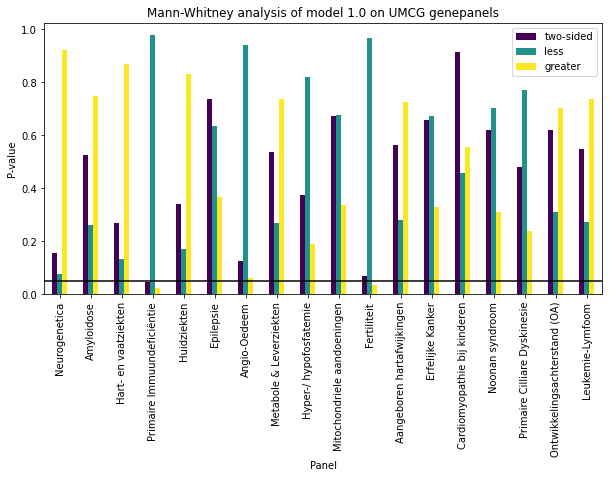

In [49]:
ax = model1_umcg_genepanel_analysis.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of model 1.0 on UMCG genepanels')
ax.hlines(y=0.05,xmin=-10,xmax=100)
ax.set_ylabel('P-value')
ax.set_xlabel('Panel')

### Base | Default hyper | balanced ds
[(Back)](#Full-dataset-AUC-analysis)

In [50]:
train_output = read_capice_output('./test_output/model_2_0/default_hyper/result_files/train_model2_defaulthyper_balancedds.txt')
test_output = read_capice_output('./test_output/model_2_0/default_hyper/result_files/test_model2_defaulthyper_balancedds.txt')
train_output, test_output = auc_analysis_function(train_output, test_output, return_value=True)

AUC analysis of the training dataset reveals AUC: 0.9664171030412587
AUC analysis of the testing dataset reveals AUC: 0.9394584540957758


In [51]:
train_output['source'] = 'train'
test_output['source'] = 'test'
full = train_output.append(test_output)
full.drop_duplicates(subset=['chr','pos','ref','alt'], inplace=True)
auc_analysis = analyze_auc_per_gene(full, 'auc_analysis_bdhbd.csv')

In [52]:
# The 10 worst performing genes in the new model.

auc_analysis.sort_values(by='auc').head(10)

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
2310,2310,SMPX,0.000000,0.000000,0.0,1.0,0.000000,5,1,6,5,1
2273,2273,MEIS2,0.000000,0.333333,1.0,0.0,0.200000,4,1,5,4,1
1269,1269,SORD,0.000000,0.500000,1.0,0.0,0.333333,2,1,3,2,1
2330,2330,LIPE,0.000000,0.500000,1.0,0.0,0.333333,2,1,3,3,0
1787,1787,MFAP5,0.050000,0.000000,0.0,1.0,0.000000,40,1,41,38,3
2303,2303,ZNF711,0.080000,0.000000,0.0,1.0,0.000000,25,1,26,25,1
1256,1256,MAG,0.166667,0.285714,1.0,0.0,0.166667,6,1,7,7,0
2069,2069,ANKRD26,0.207547,0.000000,0.0,1.0,0.000000,53,1,54,54,0
2073,2073,TUBB1,0.219512,0.058824,1.0,0.0,0.030303,41,1,42,42,0
2344,2344,EDN3,0.250000,0.000000,0.0,1.0,0.000000,8,1,9,8,1


In [53]:
model2_umcg_genepanel_analysis = genepanel_analysis(genepanels, auc_analysis)
model2_umcg_genepanel_analysis

,two-sided,less,greater,category,compared_to
0,0.014674,0.992873,0.007337,all,Neurogenetica
1,0.620671,0.310336,0.702030,all,Amyloidose
2,0.000795,0.000397,0.999616,all,Hart- en vaatziekten
3,0.994824,0.502588,0.502588,all,Primaire Immuundeficiëntie
4,0.432460,0.787554,0.216230,all,Huidziekten
5,0.063849,0.968844,0.031924,all,Epilepsie
6,0.203161,0.904554,0.101580,all,Angio-Oedeem
7,0.836416,0.418208,0.588791,all,Metabole & Leverziekten
8,0.179176,0.915998,0.089588,all,Hyper-/ hypofosfatemie
9,0.229403,0.892002,0.114702,all,Mitochondriele aandoeningen


Text(0.5, 0, 'Panel')

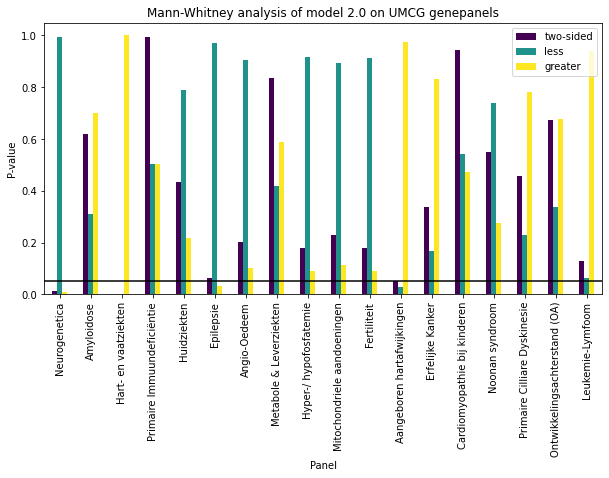

In [54]:
ax = model2_umcg_genepanel_analysis.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of model 2.0 on UMCG genepanels')
ax.hlines(y=0.05,xmin=-10,xmax=100)
ax.set_ylabel('P-value')
ax.set_xlabel('Panel')

In [55]:
previous_model_auc = pd.read_csv('/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/auc_results.csv', index_col=0)
previous_model_auc = previous_model_auc[['Gene', 'AUC']]
previous_model_auc.columns = ['gene', 'auc_previous']

In [56]:
# On average, the new model does perform better

print(f"Mean of previous model: {previous_model_auc['auc_previous'].mean()} \nMedian of previous model: {previous_model_auc['auc_previous'].median()}")

Mean of previous model: 0.9448573343008154 
Median of previous model: 0.96875


In [57]:
old_new = auc_analysis.merge(previous_model_auc, how='left')
old_new

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test,auc_previous
0,0,LDLR,0.954943,0.896552,1.0,0.0,0.812500,336,1144,1480,1325,155,0.905925
1,1,PTEN,0.941198,0.793893,1.0,0.0,0.658228,231,312,543,503,40,0.931416
2,2,BRCA1,0.986462,0.862291,1.0,0.0,0.757919,849,1938,2787,2226,561,0.949156
3,3,MLH1,0.958150,0.861732,1.0,0.0,0.757055,291,617,908,736,172,0.936598
4,4,KCNQ2,0.971511,0.739130,1.0,0.0,0.586207,153,170,323,314,9,0.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2349,GP6,0.805556,0.000000,0.0,1.0,0.000000,18,2,20,20,0,1.000000
2350,2350,AURKC,1.000000,1.000000,1.0,0.0,1.000000,5,1,6,6,0,1.000000
2351,2351,HIST1H1E,0.800000,0.000000,0.0,1.0,0.000000,5,1,6,5,1,0.875000
2352,2352,EFHB,1.000000,0.000000,0.0,1.0,0.000000,1,1,2,2,0,1.000000


In [58]:
unmerged = previous_model_auc.merge(auc_analysis, how='left').dropna(subset=['auc_previous'])
unmerged['auc'].isnull().any()

# No genes are missing from the previous dataset, so essentially only more genes got an AUC now.

False

In [59]:
old_new['delta'] = old_new['auc'] - old_new['auc_previous']

In [60]:
n_improved = old_new[old_new['delta'] > 0].shape[0]
n_i_p = n_improved / old_new.shape[0] * 100
n_worsen = old_new[old_new['delta'] < 0].shape[0]
n_w_p = n_worsen / old_new.shape[0] * 100
n_same = old_new[old_new['delta'] == 0].shape[0]
n_s_p = n_same / old_new.shape[0] * 100
n_no_data = old_new.shape[0] - (n_improved + n_worsen + n_same)
n_nd_p = n_no_data / old_new.shape[0] * 100
print(
    f"The amount of genes that improved: {n_improved}({round(n_i_p)}%),\n"
    f"The amount of genes worsen: {n_worsen}({round(n_w_p)}%),\n"
    f"and the amount of genes stayed the same: {n_same}({round(n_s_p)}%),\n"
    f"(no data: {n_no_data}({round(n_nd_p)}%))"
)

The amount of genes that improved: 856(36%),
The amount of genes worsen: 1040(44%),
and the amount of genes stayed the same: 396(17%),
(no data: 62(3%))


In [61]:
old_new_2 = old_new.where(
    (old_new['auc'] != 0.5) & 
    (old_new['auc'] != 1.0) & 
    (old_new['auc_previous'] != 0.5) & 
    (old_new['auc_previous'] != 1.0)
)

In [62]:
old_new_2.dropna(subset=['gene'], inplace=True)
old_new_2

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test,auc_previous,delta
0,0.0,LDLR,0.954943,0.896552,1.0,0.0,0.812500,336.0,1144.0,1480.0,1325.0,155.0,0.905925,0.049019
1,1.0,PTEN,0.941198,0.793893,1.0,0.0,0.658228,231.0,312.0,543.0,503.0,40.0,0.931416,0.009782
2,2.0,BRCA1,0.986462,0.862291,1.0,0.0,0.757919,849.0,1938.0,2787.0,2226.0,561.0,0.949156,0.037306
3,3.0,MLH1,0.958150,0.861732,1.0,0.0,0.757055,291.0,617.0,908.0,736.0,172.0,0.936598,0.021553
4,4.0,KCNQ2,0.971511,0.739130,1.0,0.0,0.586207,153.0,170.0,323.0,314.0,9.0,0.950000,0.021511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2338,2338.0,NEFH,0.897059,0.200000,1.0,0.0,0.111111,68.0,1.0,69.0,55.0,14.0,0.879630,0.017429
2339,2339.0,CFC1,0.350877,0.000000,0.0,1.0,0.000000,57.0,1.0,58.0,58.0,0.0,0.973684,-0.622807
2342,2342.0,CFHR4,0.736842,0.000000,0.0,1.0,0.000000,19.0,1.0,20.0,19.0,1.0,NaN,NaN
2344,2344.0,EDN3,0.250000,0.000000,0.0,1.0,0.000000,8.0,1.0,9.0,8.0,1.0,NaN,NaN


In [63]:
old_new_2['delta'] = old_new_2['auc_previous'] - old_new_2['auc']
old_new_2.sort_values(by=['delta'], ascending=False)

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test,auc_previous,delta
2303,2303.0,ZNF711,0.080000,0.000000,0.0,1.0,0.000000,25.0,1.0,26.0,25.0,1.0,0.916667,0.836667
2069,2069.0,ANKRD26,0.207547,0.000000,0.0,1.0,0.000000,53.0,1.0,54.0,54.0,0.0,0.971698,0.764151
1256,1256.0,MAG,0.166667,0.285714,1.0,0.0,0.166667,6.0,1.0,7.0,7.0,0.0,0.916667,0.750000
2332,2332.0,SHOX,0.277778,0.000000,0.0,1.0,0.000000,18.0,1.0,19.0,19.0,0.0,0.972222,0.694444
2073,2073.0,TUBB1,0.219512,0.058824,1.0,0.0,0.030303,41.0,1.0,42.0,42.0,0.0,0.902439,0.682927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2310,2310.0,SMPX,0.000000,0.000000,0.0,1.0,0.000000,5.0,1.0,6.0,5.0,1.0,NaN,NaN
2330,2330.0,LIPE,0.000000,0.500000,1.0,0.0,0.333333,2.0,1.0,3.0,3.0,0.0,NaN,NaN
2336,2336.0,APOL1,0.814815,0.000000,0.0,1.0,0.000000,81.0,1.0,82.0,81.0,1.0,NaN,NaN
2342,2342.0,CFHR4,0.736842,0.000000,0.0,1.0,0.000000,19.0,1.0,20.0,19.0,1.0,NaN,NaN


In [64]:
old_new_2[old_new_2['delta'] > 0]

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test,auc_previous,delta
8,8.0,MYBPC3,0.904018,0.708676,1.000000,0.000000,0.548798,334.0,388.0,722.0,662.0,60.0,0.938235,0.034217
9,9.0,MSH6,0.931629,0.701169,1.000000,0.000000,0.539846,422.0,420.0,842.0,764.0,78.0,0.941247,0.009618
10,10.0,COL6A1,0.971930,0.518182,0.982759,0.017241,0.351852,164.0,58.0,222.0,218.0,4.0,0.981818,0.009888
12,12.0,MSH2,0.950173,0.771192,0.998350,0.001650,0.628245,390.0,606.0,996.0,850.0,146.0,0.955128,0.004955
18,18.0,BRIP1,0.911624,0.508418,1.000000,0.000000,0.340858,348.0,151.0,499.0,480.0,19.0,0.959770,0.048146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,2311.0,CA8,0.666667,0.250000,1.000000,0.000000,0.142857,6.0,1.0,7.0,7.0,0.0,0.916667,0.250000
2322,2322.0,PITX3,0.333333,0.222222,1.000000,0.000000,0.125000,9.0,1.0,10.0,7.0,3.0,0.916667,0.583333
2332,2332.0,SHOX,0.277778,0.000000,0.000000,1.000000,0.000000,18.0,1.0,19.0,19.0,0.0,0.972222,0.694444
2339,2339.0,CFC1,0.350877,0.000000,0.000000,1.000000,0.000000,57.0,1.0,58.0,58.0,0.0,0.973684,0.622807


# AUC analysis of dyslipid model
[Index](#Index)

In [65]:
test_dyslipid = read_capice_output('./test_output/test_results_dyslipid_correct_threshold.txt')
test_dyslipid

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,STOP_GAINED,34.000,9.999996e-01,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT
1,BRCA2,FRAME_SHIFT,26.900,9.999989e-01,Pathogenic,Pathogenic,13,32912883,CTG,TT
2,BRCA1,FRAME_SHIFT,22.000,9.999983e-01,Pathogenic,Pathogenic,17,41245330,CTTTA,TTT
3,BRCA1,FRAME_SHIFT,22.000,9.999982e-01,Pathogenic,Pathogenic,17,41245404,GTA,CT
4,BRCA2,FRAME_SHIFT,22.600,9.999980e-01,Pathogenic,Pathogenic,13,32915061,TA,T
...,...,...,...,...,...,...,...,...,...,...
10837,BLOC1S1-RDH5,DOWNSTREAM,8.009,1.597412e-07,Neutral,Neutral,12,56115746,G,C
10838,LOC100289580,UPSTREAM,0.168,7.783050e-08,Neutral,Neutral,16,88801032,G,T
10839,MYHAS,DOWNSTREAM,0.035,6.001463e-08,Neutral,Neutral,17,10442488,G,A
10840,LOC100289580,UPSTREAM,1.856,4.832236e-08,Neutral,Neutral,16,88798720,G,A


In [66]:
test_dyslipid = test_dyslipid.merge(test_in)

NameError: name 'test_in' is not defined

In [ ]:
test_dyslipid['prediction'].replace({'Pathogenic': 1, 'Neutral': 0}, inplace=True)
test_dyslipid['label'].replace({'Pathogenic': 1, 'Benign': 0}, inplace=True)

In [ ]:
y_true = np.array(test_dyslipid['label'])
y_pred = np.array(test_dyslipid['prediction'])
print(f"AUC value of test dataset dyslipid model: {roc_auc_score(y_true, y_pred)}")

In [ ]:
train_dyslipid = read_capice_output('./test_output/train_results_dyslipid_correct_threshold.txt')
train_dyslipid

In [ ]:
train_merge = train[['#Chrom', 'Pos', 'Ref', 'Alt', 'label']]
train_merge.columns = ['chr','pos','ref','alt','label']
train_merge

In [ ]:
train_dyslipid = train_dyslipid.merge(train_merge)
train_dyslipid['prediction'].replace({'Pathogenic': 1, 'Neutral': 0}, inplace=True)
train_dyslipid['label'].replace({'Pathogenic': 1, 'Benign': 0}, inplace=True)
train_dyslipid

In [ ]:
y_true = np.array(train_dyslipid['label'])
y_pred = np.array(train_dyslipid['prediction'])
print(f"AUC value of train dataset dyslipid model: {roc_auc_score(y_true, y_pred)}")

In [ ]:
train_dyslipid['source'] = 'train'
test_dyslipid['source'] = 'test'
dyslipid_full = train_dyslipid.append(test_dyslipid)

In [ ]:
dyslipid_auc_analysis = analyze_auc_per_gene(dyslipid_full, 'auc_analysis_dyslipid.csv')
dyslipid_auc_analysis

In [ ]:
dyslipid_genepanel_analysis = genepanel_analysis(genepanels, dyslipid_auc_analysis)
dyslipid_genepanel_analysis

In [ ]:
ax = dyslipid_genepanel_analysis.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all, new dyslipid model.')
ax.hlines(y=0.05,xmin=-10,xmax=100)
ax.set_ylabel('P-value')
ax.set_xlabel('Panel')

# AUC analysis on EK model
[Index](#Index)

# Model on best performing panel, prepartation
[Index](#Index)

In [ ]:
ek = genepanels['Erfelijke Kanker']
ek

In [ ]:
ek_genes = []
for key, values in ek.items():
    for value in values:
        if value not in ek_genes:
            ek_genes.append(value)
len(ek_genes)

In [ ]:
ek_subset = train.loc[train['GeneName'].isin(ek_genes)]
ek_subset

In [ ]:
ek_subset['label'].value_counts()

# AUC analysis new model on UMCG genepanels
[Index](#Index)

In [ ]:
auc_analysis

In [ ]:
genepanel_auc = genepanel_analysis(genepanels, auc_analysis)
genepanel_auc.sort_values(by='compared_to', inplace=True)

In [ ]:
previous_model_auc = pd.read_csv('./not_saving_directory/previousmodelauc.csv')
previous_model_auc.sort_values(by='compared_to', inplace=True)

In [ ]:
ax = genepanel_auc.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all, new full model.')
ax.hlines(y=0.05,xmin=-10,xmax=100)
ax.set_ylabel('P-value')
ax.set_xlabel('Panel')

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(200,100), sharex=True)
previous_model_auc.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all, old model.', ax=axes[0])
axes[0].hlines(y=0.05,xmin=-10,xmax=100)
axes[0].set_ylabel('P-value')
axes[0].set_xlabel('Panel')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2,1))
genepanel_auc.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all, new v2 model.', ax=axes[1])
axes[1].get_legend().remove()
axes[1].set_ylabel('P-value')
axes[1].hlines(y=0.05,xmin=-10,xmax=100)

# Corrected UMCG genepanel analysis
[Index](#Index)

# Barplot of type of variants for each panel
[Index](#Index)

In [ ]:
variants = pd.read_csv('/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/datafiles/train.txt.gz', compression='gzip', sep='\t', low_memory=False)
variants

In [ ]:
ax = variants['Consequence'].value_counts().plot(kind='bar')
ax.set_title('Type of SNV over the entire training dataset.')
ax.set_ylabel('Count')
ax.set_xlabel('Consequence')

In [ ]:
# Reduce the information to just panels.

panels = {}
for panel in genepanels.keys():
    panels[panel] = []
    disease_panel = genepanels[panel]
    if isinstance(disease_panel, dict):
        for disease, genes in disease_panel.items():
            for gene in genes:
                if gene not in panels[panel]:
                    panels[panel].append(gene)

In [ ]:
for panel, genes in panels.items():
    title = f'Type of SNV over the entire training dataset, panel: {panel}'
    subset = variants[variants['GeneName'].isin(genes)]
    data = subset['Consequence'].value_counts()
    ax = data.plot.bar(x='index', y='Consequence',
                      colormap='viridis',
                      title=title)
    ax.set_ylabel('Count')
    ax.set_xlabel('Panel')
    fig = plt.Figure()
    fig.axes.append(ax)
    plt.show()